In [2]:
import pandas as pd
import polars as pl
import numpy as np
import time
from tqdm.auto import tqdm
import os
from itertools import cycle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import Transform

---
# Script Variabels

In [103]:
dataset_name = 'Kenya_90k_Set_1_w90_pW'
center_type = 'kMedoids'

In [31]:
dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'

window_cols, window_len = Transform.retrive_window_col_names(dataset_name)

In [32]:
# Pairing Soltuion type with Name
if dataset_name == 'Kenya_90k_Set_1_w90_pW':
    sol_names_dict = {
        'LSTM': f'LSTM_AE-efficient_sweep_2_v49',
        'CNN_ConvEmb': f'CNN_ConvEmb-vague_sweep_1_v41',
        'CNN_AE': f'CNN_AE-trim_sweep_2_v24',
        'FC_N2D': f'FC_N2D-sage_sweep_1_v90',
        'Shallow_kMeans': f'Shallow-kMeans'
    }

In [53]:
# Automatinc Solution CSV location link
sol_location_dict = {
    'LSTM': f"../ModelResults/Clustering/Solutions/{dataset_name}/{sol_names_dict['LSTM']}.csv",
    'CNN_ConvEmb': f"../ModelResults/Clustering/Solutions/{dataset_name}/{sol_names_dict['CNN_ConvEmb']}.csv",
    'CNN_AE': f"../ModelResults/Clustering/Solutions/{dataset_name}/{sol_names_dict['CNN_AE']}.csv",
    'FC_N2D': f"../ModelResults/Clustering/Solutions/{dataset_name}/{sol_names_dict['FC_N2D']}.csv",
    'Shallow_kMeans': f"../ModelResults/Clustering/Solutions/{dataset_name}/{sol_names_dict['Shallow_kMeans']}.csv",
}

# Automatinc Cluster Center CSV location link
def center_location_finder(model, center_type, dataset_name =dataset_name, sol_names_dict =sol_names_dict):
    
    center_dict = {'kMedoids':'-kMedoid_DTW_Centers', 'DTW':'-DTW_Centers', 'Euc':'-Euc_Centers'}

    center_location_dict = {
        'LSTM':  f"../ModelResults/Clustering/Centroids/{dataset_name}/{sol_names_dict['LSTM'] + center_dict[center_type]}.csv", 
        'CNN_ConvEmb': f"../ModelResults/Clustering/Centroids/{dataset_name}/{sol_names_dict['CNN_ConvEmb'] + center_dict[center_type]}.csv",
        'CNN_AE': f"../ModelResults/Clustering/Centroids/{dataset_name}/{sol_names_dict['CNN_AE'] + center_dict[center_type]}.csv",
        'FC_N2D': f"../ModelResults/Clustering/Centroids/{dataset_name}/{sol_names_dict['FC_N2D'] + center_dict[center_type]}.csv",
        'Shallow_kMeans': f"../ModelResults/Clustering/Centroids/{dataset_name}/{sol_names_dict['Shallow_kMeans'] + center_dict[center_type]}.csv",
    }
    
    return center_location_dict[model]

---
# Data Imports

### Payment Data

In [36]:
df_data_ids = pl.scan_csv(dataset_location).select(["short_ID", "window_ID"]).collect()
df_data_ids = df_data_ids.with_columns([pl.Series(name="index", values=np.arange(len(df_data_ids)))])

df_data = pl.read_csv(dataset_location)

---
# Centroid Visualization

## Plotting Functions

In [40]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [41]:
def human_format(number):
    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    return '%.2f%s' % (number / k**magnitude, units[magnitude])

In [95]:
def plot_all_elbow(sol_names = ['LSTM', 'CNN_ConvEmb', 'CNN_AE', 'FC_N2D'], center_type = 'kMedoids', algs = ['KUMAP','kMeans'], var = 'Total_Score', line_type = 'avg'):  
    
    #Initiate Figure
    fig = go.Figure()
    # Set line colours to select from
    kmeans_palette = cycle(px.colors.sequential.matter)
    KUMAP_palette = cycle(px.colors.sequential.Aggrnyl)
    palette = cycle(px.colors.qualitative.T10)
    
    # Cycle through Solutions and Algorithms
    for i, sol_name in enumerate(sol_names):
        # Load centers for Solution
        center_location = center_location_finder(sol_name, center_type)
        df_centers = pl.read_csv(center_location).to_pandas()
        
        # Load Data for Each Elbow Line, i.e., there's one per Algorithm for each Solution
        for alg in algs:
            # Elbow line, as SUM os all points for selected Var (e.g., Total_Score)
            if line_type == 'sum': 
                df_line = df_centers[df_centers['Algorithm']==alg][['k', var]].groupby('k').agg('sum').reset_index()
                df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
                df_line.sort_values(by=['sort'], inplace= True)
                line_name = 'Total Sum'
            # Elbow line, as weighted Average os all points for selected Var (e.g., Total_Score)    
            elif line_type == 'w_avg':
                df_line = df_centers[df_centers['Algorithm']==alg][['Cluster_Size', 'k', var]].groupby('k').apply(w_avg, var, 'Cluster_Size').reset_index()
                df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
                df_line.sort_values(by=['sort'], inplace= True)
                df_line.rename(columns={0: var}, inplace=True)    
                line_name = 'Weighted Average'
                
            # (...) As simple Average    
            elif line_type == 'avg':
                df_line = df_centers[df_centers['Algorithm']==alg][['k', var]].groupby('k').agg('mean').reset_index()
                df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
                df_line.sort_values(by=['sort'], inplace= True)
                line_name = 'Average'
                
            # Adding Elbow line to Plot
            if alg == 'kMeans':
                # palette = kmeans_palette
                line_style =dict(width=2, color=next(palette), dash = 'dash')
            elif alg == 'KUMAP':
                # palette = KUMAP_palette
                line_style =dict(width=2, color=next(palette))
            
            line_name = sol_name + f'-{alg}'
            fig.add_trace(
                go.Scatter(
                    x=df_line['k'],
                    y=df_line[var],
                    mode = 'lines+markers',
                    name = line_name,
                    # marker_color='rgba(128, 0, 0, .6)',
                    hovertemplate='%{y:.2s}',
                    line=line_style
                )
            )
        
        
    # Figure Style
    title_text = f'<b>{center_type}</b> - {var} [{line_type.capitalize()}]'
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        hovermode = 'x',
        showlegend = True,
        legend=dict(
            orientation = 'h',
            yanchor="middle",
            y=-.2,
            x = 0.5,
            xanchor="center",
        ), 
        title={
            'text': title_text,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    
    fig.show()

In [120]:
def plot_elbow(sol_name = 'LSTM', center_type = 'kMedoids', alg = 'KUMAP', var = 'Total_Score', line_type = 'w_avg'):
    
    # Load centers for Solution
    center_location = center_location_finder(sol_name, center_type)
    df = pl.scan_csv(center_location).filter(pl.col(f"Algorithm") == alg).collect().to_pandas()

    
    # df = df_centers[df_centers['Algorithm'] == alg]
    
    if line_type == 'avg': 
        df_line = df[['k', var]].groupby('k').agg('mean').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        line_name = 'Average'
        
    elif line_type == 'w_avg':
        df_line = df[['Cluster_Size', 'k', var]].groupby('k').apply(w_avg, var, 'Cluster_Size').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        df_line.rename(columns={0: var}, inplace=True)    
        line_name = 'Weighted Avg'
    
    elif line_type == 'sum':
        df_line = df[['k', var]].groupby('k').agg('sum').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        line_name = 'Sum'
        
    
    fig = go.Figure()

    fig.add_trace(
        go.Box(
            y=df[var],
            x=df['k'],
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.5,
            fillcolor='rgba(75, 119, 190, .5)',
            marker_size=3,
            line_width=1.5,
            line_color = 'rgba(75, 119, 190, .9)',
            hoverinfo = 'skip'
        )
    )
        
    fig.add_trace(
        go.Scatter(
            x=df_line['k'],
            y=df_line[var],
            mode = 'lines+markers',
            name = line_name,
            marker_color='rgba(128, 0, 0, .6)',
            hovertemplate='%{y:.2s}'
        )
    )
        
    # Figure Style
    # if len(sol_name) > 0:
    #     # sol_name = sol_name.split('-')[0]
    #     title_text = f'<b>{sol_name} {alg}</b> - Var: {mode}'
    # else:
    #     title_text = f'<b>{alg}</b> - Var: {mode}'
    title_text = f'<b>{sol_name}-{alg}</b> - {var} -> {center_type} [{line_name}]'
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        showlegend = False,
        hovermode = 'x',
        title={
            'text': title_text,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    
    fig.show()

In [150]:
def plot_centers(sol_name = 'LSTM', center_type = 'kMedoids', alg = 'KUMAP', k = 'k10'):
    
    # Load centers for Solution
    center_location = center_location_finder(sol_name, center_type)
    df = pl.scan_csv(center_location).filter((pl.col(f"Algorithm") == alg) & (pl.col(f"k") == k)).collect().to_pandas()
    sol_cols = pl.scan_csv(sol_location_dict[sol_name]).columns[5:]

    
    # df = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k)]
    # sol_cols = pl.scan_csv(sol_location).columns[5:]

    max_c = int(sol_cols[-1].split('_')[-1][1:])

    fig = go.Figure()
    palette = cycle(px.colors.qualitative.T10)
    for c in range(1, max_c +1):
        fig.add_trace(
            go.Scatter(
                x=window_cols,
                y= df[df['cluster'] == c][window_cols].values.ravel(),
                mode='lines',
                name= f'Cluster: {c}',
                hovertemplate='%{y:.1f}',
                line=dict(width=2, color=next(palette))
            )
        )
        
    # fig.update_layout(
    #     margin=dict(l=20, r=20, t=20, b=20),
    #     template="seaborn",
    #     showlegend = True 
    # )
    # Figure Style
    if len(sol_name) > 0:
        sol_name = sol_name.split('-')[0]
        title_text = f'<b>{sol_name} {alg}</b>: {k} -> {center_type}'
    else:
        title_text = f'<b>{alg}</b> - {center_type}'
    
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        hovermode = 'x',        
        showlegend = True,
        legend=dict(
            yanchor="middle",
            y=0.5,
            xanchor="left",
        ),
        title={
            'text': title_text,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    fig.show()

In [193]:
def plot_cluster_samples (sol_name = 'LSTM', center_type = 'kMedoids', alg = 'KUMAP', k = 'k10', cluster = 1, sample = 10, seed = 42):
    
    # Load centers for Solution
    center_location = center_location_finder(sol_name, center_type)
    df = pl.scan_csv(center_location).filter((pl.col(f"Algorithm") == alg) & (pl.col(f"k") == k) & (pl.col(f"cluster") == cluster)).collect().to_pandas()
    center = df[window_cols].values.ravel()
    
    if seed == 'random':
        seed = np.random.randint(1, high=100, size=1)[0]
    elif isinstance(seed, int):
        seed = seed
    else:
        print('Error: Invalid seed input.')

    
    sol = ('_').join([alg, k])    
    df_ids = pl.scan_csv(sol_location_dict[sol_name]).filter(pl.col(f"{sol}") == cluster).select(["short_ID", "window_ID"]).collect().sample(n=sample, seed=seed)  
    df_samples = df_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
    samples = df_samples[window_cols].values
    
    fig = go.Figure()
       
    # Samples
    for sample in samples:
        fig.add_trace(
            go.Scatter(
                x = window_cols,
                y = sample,
                mode = 'lines',
                name = 'Average',
                marker_color='rgba(36, 37, 42, .25)',
                hoverinfo='skip'
            )
        )    
        
    # Center Line
    fig.add_trace(
        go.Scatter(
            x = window_cols,
            y = center,
            mode = 'lines',
            name = 'Cluster Center',
            line=dict(color='rgba(217, 30, 24, .8)', width=3.5),
            hovertemplate='%{y:.2f}',
        )
    )
 
    
    # Figure Style
    title_text = f'<b>Cluster: {cluster}</b> || {sol_name} - {alg} <i>[{k} - {center_type}]</i>'
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        showlegend = False,
        hovermode = 'x',
        title={
            'text': title_text ,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    fig.show()
    print(f'seed: {seed}')

---
# Figures

## General Comparission

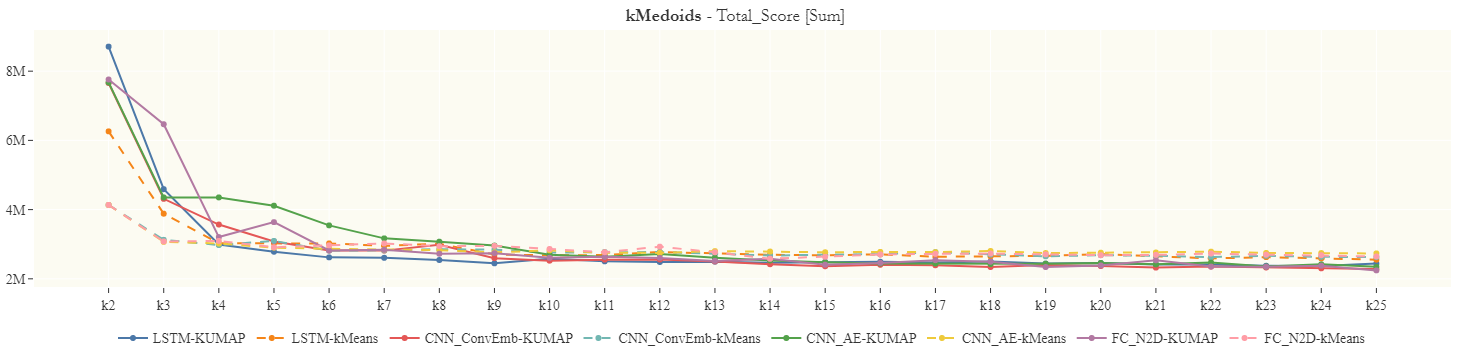

In [102]:
plot_all_elbow(var = 'Total_Score', line_type = 'sum', center_type = 'kMedoids')

## Individual Solutions

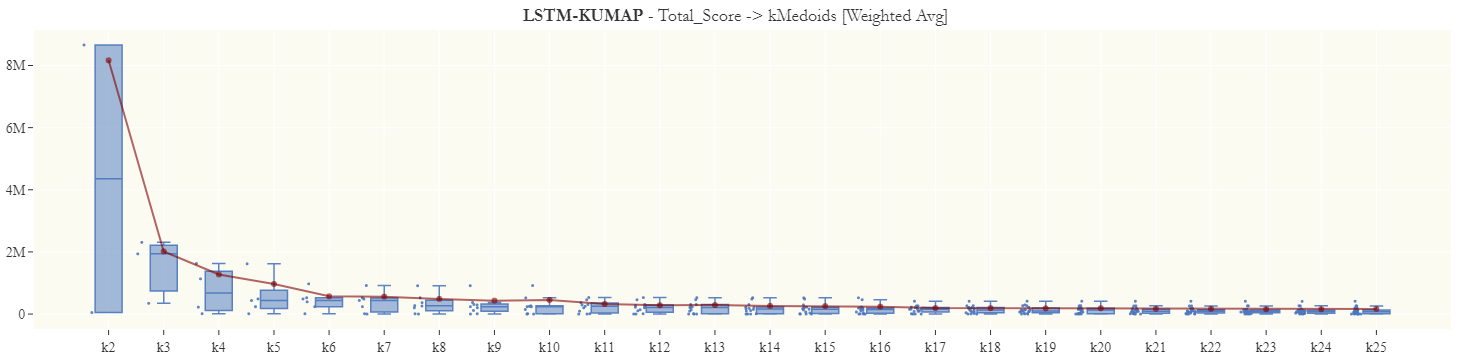

In [197]:
plot_elbow(sol_name= 'LSTM', var = 'Total_Score', line_type = 'w_avg', center_type = 'kMedoids')

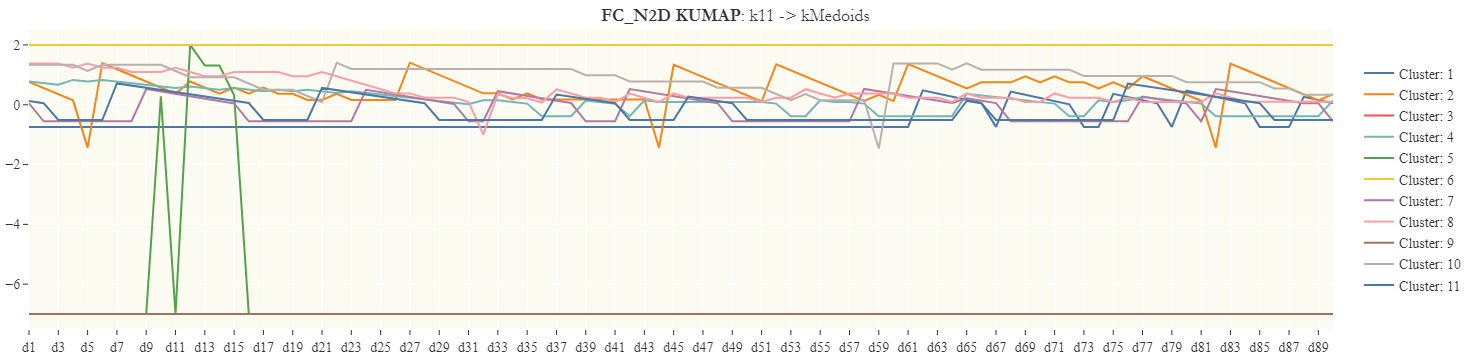

In [200]:
plot_centers(sol_name= 'FC_N2D', center_type = 'kMedoids', alg = 'KUMAP', k = 'k11')

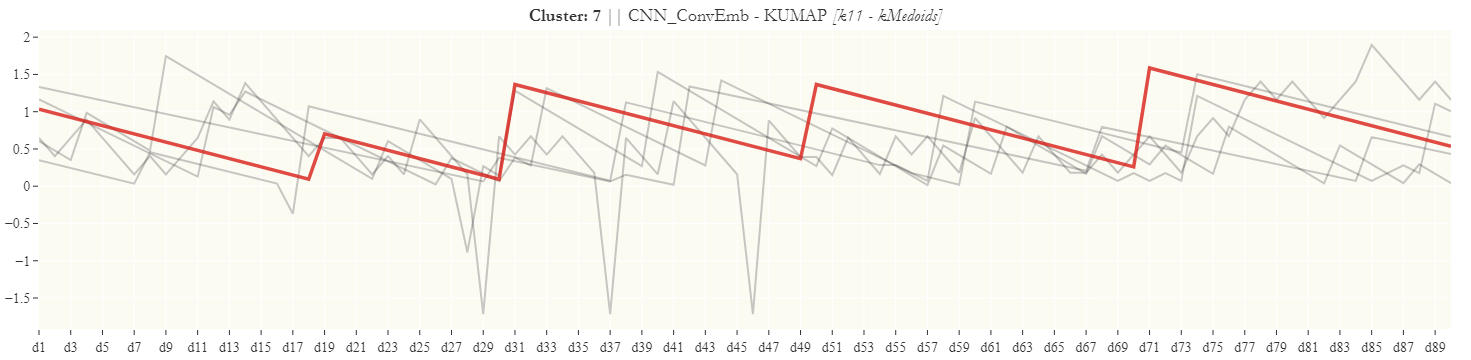

seed: 18


In [195]:
plot_cluster_samples(sol_name = 'CNN_ConvEmb', center_type = 'kMedoids', alg = 'KUMAP', k = 'k11', cluster = 7, sample = 5, seed = 'random')